In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint

In [2]:
#read data
df = pd.read_csv("RFLFSODataFull.csv")

In [3]:
#import variables
variables = {
    'Overall_FSO_Att': ['Time','TemperatureMin','Particulate','AbsoluteHumidity','VisibilityMin','ParticulateMin','Temperature','Visibility','Distance'],
    'Overall_RFL_Att': ['Visibility','RainIntensityMin','Temperature','RainIntensityMax','Distance','RainIntensity','AbsoluteHumidity'],

    'SynopCode_0_FSO_Att': ['Time','Visibility','TemperatureMax','AbsoluteHumidity','VisibilityMax','VisibilityMin','TemperatureMin','Temperature','Distance'],
    'SynopCode_0_RFL_Att': ['Time','VisibilityMin','Frequency','Visibility','Temperature','AbsoluteHumidityMax','AbsoluteHumidityMin','AbsoluteHumidity','Distance'],
    
    'SynopCode_3_FSO_Att': ['TemperatureMin','Time'],
    'SynopCode_3_RFL_Att': ['Temperature','Distance','VisibilityMax'],
    
    'SynopCode_4_FSO_Att': ['Visibility','Distance','ParticulateMax','Temperature','ParticulateMin','Particulate'],
    'SynopCode_4_RFL_Att': ['Visibility','RainIntensityMax','AbsoluteHumidity','TemperatureMin','RainIntensity','RainIntensityMin','AbsoluteHumidityMin','RelativeHumidity'],
    
    'SynopCode_5_FSO_Att': ['Temperature','Visibility','ParticulateMax','Distance'],
    'SynopCode_5_RFL_Att': ['TemperatureDifference','Frequency','RainIntensityMin','Visibility','RelativeHumidity','Distance','RainIntensity','RainIntensityMax','AbsoluteHumidityMax','AbsoluteHumidityMin','AbsoluteHumidity'],
    
    'SynopCode_6_FSO_Att': ['Time','TemperatureDifference','VisibilityMax','RelativeHumidity','ParticulateMin','AbsoluteHumidity','Visibility','Temperature','ParticulateMax','Distance','Particulate'],
    'SynopCode_6_RFL_Att': ['Distance','Visibility','Temperature','RainIntensityMax','RainIntensityMin','AbsoluteHumidity','RainIntensity'],
   
    'SynopCode_7_FSO_Att': ['RelativeHumidity','Temperature','ParticulateMin','TemperatureDifference','ParticulateMax','Particulate'],
    'SynopCode_7_RFL_Att': ['Time','WindSpeedMax','RainIntensity','TemperatureDifference'],
   
    'SynopCode_8_FSO_Att': ['RelativeHumidity','VisibilityMax','AbsoluteHumidity','VisibilityMin','Distance','Visibility'],
    'SynopCode_8_RFL_Att': ['Frequency','TemperatureDifference','VisibilityMax','Particulate','Distance','Temperature','ParticulateMax','Visibility','RainIntensityMax','ParticulateMin','AbsoluteHumidityMin','Visibility','RainIntensityMin','AbsoluteHumidityMax','RainIntensity','AbsoluteHumidity']
}

In [4]:
#preprocessing
df['SYNOPCode']=df['SYNOPCode'].astype('category')
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.7,test_size=0.3,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.7,test_size=0.3,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()

17789    5.347560
34045    3.155277
74826    7.838488
20102    7.629526
31307    7.337750
Name: FSO_Att, dtype: float64

In [5]:
#Function to generate dataset for each model
def g_dataset(df,vars):
    dataset=pd.DataFrame()
    for var in vars:
        dataset[var]=df[var]
    return dataset

In [6]:
#dataset split
for key, feature_vars in variables.items():
    if 'FSO_Att' in key:
        response_var = 'FSO_Att'
        y_train = y_FSO_train
        y_test = y_FSO_test
        type='FSO'
    else:
        response_var = 'RFL_Att'
        y_train = y_RFL_train
        y_test = y_RFL_test
        type='RFL'
    
    # choose different dataset for specified data
    if 'SynopCode' in key:
        synop_code = int(key.split('_')[1])
        X_train_synop = X_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
        X_test_synop = X_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
        y_train_synop = y_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
        y_test_synop = y_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
        # choosing important response var
        globals()[f'X_train_synop_{synop_code}_{type}'] = g_dataset(X_train_synop, feature_vars)
        globals()[f'X_test_synop_{synop_code}_{type}'] = g_dataset(X_test_synop, feature_vars)
        globals()[f'y_train_synop_{synop_code}_{type}'] = y_train_synop
        globals()[f'y_test_synop_{synop_code}_{type}'] = y_test_synop
        
    else:
        continue

In [7]:
# Initialize results
results = {}
#define function to train and evaluate
def train_and_evaluate_rf(Xtrain, Xtest, ytrain, ytest, model_name,best_params):
    rf_model = best_params
    rf_model.fit(Xtrain, ytrain)
    
    y_pred_train = rf_model.predict(Xtrain)
    y_pred_test = rf_model.predict(Xtest)
    
    train_rmse = np.sqrt(mean_squared_error(ytrain, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(ytest, y_pred_test))
    
    train_r2 = r2_score(ytrain, y_pred_train)
    test_r2 = r2_score(ytest, y_pred_test)
    results[model_name] = {'rmse': test_rmse, 'r2': test_r2}
    if 'FSO' in model_name:
        X_test_fso=X_test[X_test['SYNOPCode']==int(model_name.split('_')[1])].reset_index(drop=True)
        X_overall_fso_test=g_dataset(X_test_fso,variables['Overall_FSO_Att'])
        overall_y_pred=Overall_FSO_Att.predict(X_overall_fso_test)
        overall_r2=r2_score(ytest, overall_y_pred)
        overall_rmse=np.sqrt(mean_squared_error(ytest, overall_y_pred))
        results[f"{model_name}_overall"] = {'rmse': overall_rmse, 'r2': overall_r2}
    if 'RFL' in model_name:
        X_test_rfl=X_test[X_test['SYNOPCode']==int(model_name.split('_')[1])].reset_index(drop=True)
        X_overall_rfl_test=g_dataset(X_test_rfl,variables['Overall_RFL_Att'])
        overall_y_pred=Overall_RFL_Att.predict(X_overall_rfl_test)
        overall_r2=r2_score(ytest, overall_y_pred)
        overall_rmse=np.sqrt(mean_squared_error(ytest, overall_y_pred))
        results[f"{model_name}_overall"] = {'rmse': overall_rmse, 'r2': overall_r2}

    print(f"Train RMSE for {model_name}: {train_rmse}")
    print(f"Test RMSE for {model_name}: {test_rmse}")
    print(f"Train R² for {model_name}: {train_r2}")
    print(f"Test R² for {model_name}: {test_r2}")
    
    # save model
    joblib.dump(rf_model, f"{model_name}.joblib")
    
    return rf_model

In [8]:
# Function to perform hyperparameter tuning
def hyperparameter_tuning(X_train, X_test,y_train, y_test,model_name):
    # Define the parameter grid
    param_dist = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(10, 50),     
        'min_samples_split': randint(2, 10),  
        'min_samples_leaf': randint(1, 4),   
        'max_features': ['log2','sqrt'], 
    }

    # Initialize the RandomForest model
    rf = RandomForestRegressor(random_state=1874845)

    # Use RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=rf, 
        param_distributions=param_dist, 
        n_iter=50,  
        cv=3, 
        scoring='neg_mean_squared_error', 
        verbose=2, 
        random_state=1874845, 
        n_jobs=6  
    )

    # Fit the model
    random_search.fit(X_train, y_train)

    # Get the best model
    best_rf = random_search.best_estimator_

    # Predict and evaluate performance on test data
    y_pred = best_rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Best Parameters of {model_name}: {random_search.best_params_}")
    print(f"Test RMSE: {rmse}")
    print(f"Test R²: {r2}")

    return best_rf, random_search.cv_results_

In [9]:
# Perform hyperparameter tuning
best_model_FSO, cv_results_FSO = hyperparameter_tuning(X_train, X_test,y_FSO_train,y_FSO_test,model_name='Generic_FSO_Att')
best_model_0_FSO, cv_results_0_FSO = hyperparameter_tuning(X_train_synop_0_FSO, X_test_synop_0_FSO, y_train_synop_0_FSO, y_test_synop_0_FSO,model_name='SynopCode_0_FSO_Att' )
best_model_3_FSO, cv_results_3_FSO = hyperparameter_tuning(X_train_synop_3_FSO, X_test_synop_3_FSO, y_train_synop_3_FSO, y_test_synop_3_FSO,model_name='SynopCode_3_FSO_Att' )
best_model_4_FSO, cv_results_4_FSO = hyperparameter_tuning(X_train_synop_4_FSO, X_test_synop_4_FSO, y_train_synop_4_FSO, y_test_synop_4_FSO,model_name='SynopCode_4_FSO_Att' )
best_model_5_FSO, cv_results_5_FSO = hyperparameter_tuning(X_train_synop_5_FSO, X_test_synop_5_FSO, y_train_synop_5_FSO, y_test_synop_5_FSO,model_name='SynopCode_5_FSO_Att' )
best_model_6_FSO, cv_results_6_FSO = hyperparameter_tuning(X_train_synop_6_FSO, X_test_synop_6_FSO, y_train_synop_6_FSO, y_test_synop_6_FSO,model_name='SynopCode_6_FSO_Att' )
best_model_7_FSO, cv_results_7_FSO = hyperparameter_tuning(X_train_synop_7_FSO, X_test_synop_7_FSO, y_train_synop_7_FSO, y_test_synop_7_FSO,model_name='SynopCode_7_FSO_Att' )
best_model_8_FSO, cv_results_8_FSO = hyperparameter_tuning(X_train_synop_8_FSO, X_test_synop_8_FSO, y_train_synop_8_FSO, y_test_synop_8_FSO,model_name='SynopCode_8_FSO_Att' )
best_model_RFL, cv_results_RFL = hyperparameter_tuning(X_train, X_test,y_RFL_train, y_RFL_test,model_name='Generic_RFL_att')
best_model_0_RFL, cv_results_0_RFL = hyperparameter_tuning(X_train_synop_0_RFL, X_test_synop_0_RFL, y_train_synop_0_RFL, y_test_synop_0_RFL,model_name='SynopCode_0_RFL_Att')
best_model_3_RFL, cv_results_3_RFL = hyperparameter_tuning(X_train_synop_3_RFL, X_test_synop_3_RFL, y_train_synop_3_RFL, y_test_synop_3_RFL,model_name='SynopCode_3_RFL_Att')
best_model_4_RFL, cv_results_4_RFL = hyperparameter_tuning(X_train_synop_4_RFL, X_test_synop_4_RFL, y_train_synop_4_RFL, y_test_synop_4_RFL,model_name='SynopCode_4_RFL_Att')
best_model_5_RFL, cv_results_5_RFL = hyperparameter_tuning(X_train_synop_5_RFL, X_test_synop_5_RFL, y_train_synop_5_RFL, y_test_synop_5_RFL,model_name='SynopCode_5_RFL_Att')
best_model_6_RFL, cv_results_6_RFL = hyperparameter_tuning(X_train_synop_6_RFL, X_test_synop_6_RFL, y_train_synop_6_RFL, y_test_synop_6_RFL,model_name='SynopCode_6_RFL_Att')
best_model_7_RFL, cv_results_7_RFL = hyperparameter_tuning(X_train_synop_7_RFL, X_test_synop_7_RFL, y_train_synop_7_RFL, y_test_synop_7_RFL,model_name='SynopCode_7_RFL_Att')
best_model_8_RFL, cv_results_8_RFL = hyperparameter_tuning(X_train_synop_8_RFL, X_test_synop_8_RFL, y_train_synop_8_RFL, y_test_synop_8_RFL,model_name='SynopCode_8_RFL_Att')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of Generic_FSO_Att: {'max_depth': 23, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 233}
Test RMSE: 0.8961546880424207
Test R²: 0.9477382299972531
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of SynopCode_0_FSO_Att: {'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 197}
Test RMSE: 0.9991852315808712
Test R²: 0.920521291323102
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of SynopCode_3_FSO_Att: {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 201}
Test RMSE: 3.142195368010067
Test R²: 0.8468577363795399
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters of SynopCode_4_FSO_Att: {'max_depth': 23, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_es

In [10]:
#train and evaluate
Overall_FSO_Att = best_model_FSO
Overall_FSO_Att.fit(g_dataset(X_train,variables['Overall_FSO_Att']), y_FSO_train)
Overall_RFL_Att = best_model_RFL
Overall_RFL_Att.fit(g_dataset(X_train,variables['Overall_RFL_Att']), y_RFL_train)
model_0_RFL=train_and_evaluate_rf(X_train_synop_0_RFL, X_test_synop_0_RFL, y_train_synop_0_RFL, y_test_synop_0_RFL,model_name='SynopCode_0_RFL_Att',best_params=best_model_0_RFL)
model_3_RFL=train_and_evaluate_rf(X_train_synop_3_RFL, X_test_synop_3_RFL, y_train_synop_3_RFL, y_test_synop_3_RFL,model_name='SynopCode_3_RFL_Att',best_params=best_model_3_RFL)
model_4_RFL=train_and_evaluate_rf(X_train_synop_4_RFL, X_test_synop_4_RFL, y_train_synop_4_RFL, y_test_synop_4_RFL,model_name='SynopCode_4_RFL_Att',best_params=best_model_4_RFL)
model_5_RFL=train_and_evaluate_rf(X_train_synop_5_RFL, X_test_synop_5_RFL, y_train_synop_5_RFL, y_test_synop_5_RFL,model_name='SynopCode_5_RFL_Att',best_params=best_model_5_RFL)
model_6_RFL=train_and_evaluate_rf(X_train_synop_6_RFL, X_test_synop_6_RFL, y_train_synop_6_RFL, y_test_synop_6_RFL,model_name='SynopCode_6_RFL_Att',best_params=best_model_6_RFL)
model_7_RFL=train_and_evaluate_rf(X_train_synop_7_RFL, X_test_synop_7_RFL, y_train_synop_7_RFL, y_test_synop_7_RFL,model_name='SynopCode_7_RFL_Att',best_params=best_model_7_RFL)
model_8_RFL=train_and_evaluate_rf(X_train_synop_8_RFL, X_test_synop_8_RFL, y_train_synop_8_RFL, y_test_synop_8_RFL,model_name='SynopCode_8_RFL_Att',best_params=best_model_8_RFL)

model_0_FSO=train_and_evaluate_rf(X_train_synop_0_FSO, X_test_synop_0_FSO, y_train_synop_0_FSO, y_test_synop_0_FSO,model_name='SynopCode_0_FSO_Att',best_params=best_model_0_FSO)
model_3_FSO=train_and_evaluate_rf(X_train_synop_3_FSO, X_test_synop_3_FSO, y_train_synop_3_FSO, y_test_synop_3_FSO,model_name='SynopCode_3_FSO_Att',best_params=best_model_3_FSO)
model_4_FSO=train_and_evaluate_rf(X_train_synop_4_FSO, X_test_synop_4_FSO, y_train_synop_4_FSO, y_test_synop_4_FSO,model_name='SynopCode_4_FSO_Att',best_params=best_model_4_FSO)
model_5_FSO=train_and_evaluate_rf(X_train_synop_5_FSO, X_test_synop_5_FSO, y_train_synop_5_FSO, y_test_synop_5_FSO,model_name='SynopCode_5_FSO_Att',best_params=best_model_5_FSO)
model_6_FSO=train_and_evaluate_rf(X_train_synop_6_FSO, X_test_synop_6_FSO, y_train_synop_6_FSO, y_test_synop_6_FSO,model_name='SynopCode_6_FSO_Att',best_params=best_model_6_FSO)
model_7_FSO=train_and_evaluate_rf(X_train_synop_7_FSO, X_test_synop_7_FSO, y_train_synop_7_FSO, y_test_synop_7_FSO,model_name='SynopCode_7_FSO_Att',best_params=best_model_7_FSO)
model_8_FSO=train_and_evaluate_rf(X_train_synop_8_FSO, X_test_synop_8_FSO, y_train_synop_8_FSO, y_test_synop_8_FSO,model_name='SynopCode_8_FSO_Att',best_params=best_model_8_FSO)


Train RMSE for SynopCode_0_RFL_Att: 0.18168833268020748
Test RMSE for SynopCode_0_RFL_Att: 0.33895358586700725
Train R² for SynopCode_0_RFL_Att: 0.9949570544981124
Test R² for SynopCode_0_RFL_Att: 0.9823454294097668
Train RMSE for SynopCode_3_RFL_Att: 0.28719860237579137
Test RMSE for SynopCode_3_RFL_Att: 0.6827468376958784
Train R² for SynopCode_3_RFL_Att: 0.9910004569588682
Test R² for SynopCode_3_RFL_Att: 0.9455078437044309
Train RMSE for SynopCode_4_RFL_Att: 0.1553087925831245
Test RMSE for SynopCode_4_RFL_Att: 0.5831766464661152
Train R² for SynopCode_4_RFL_Att: 0.9906907623474487
Test R² for SynopCode_4_RFL_Att: 0.8938291215525567
Train RMSE for SynopCode_5_RFL_Att: 0.22999804018034858
Test RMSE for SynopCode_5_RFL_Att: 0.6147139980988209
Train R² for SynopCode_5_RFL_Att: 0.9935525452545559
Test R² for SynopCode_5_RFL_Att: 0.9556352239505117
Train RMSE for SynopCode_6_RFL_Att: 0.38879967837440793
Test RMSE for SynopCode_6_RFL_Att: 1.0340309976406332
Train R² for SynopCode_6_RFL_A

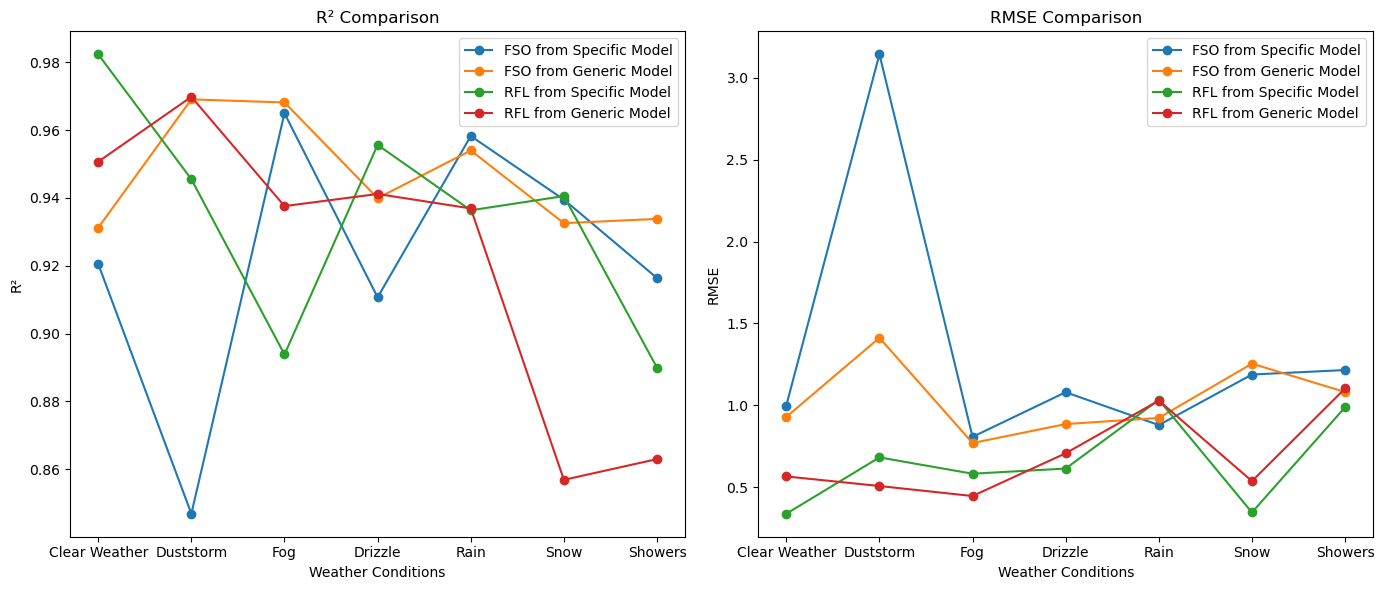

In [11]:
# plotting comparison
weather_conditions = ['SynopCode_0', 'SynopCode_3', 'SynopCode_4', 'SynopCode_5', 'SynopCode_6', 'SynopCode_7', 'SynopCode_8']
r2_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}
rmse_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}

for wc in weather_conditions:
    for var in ['FSO_Att', 'RFL_Att']:
        specific_key = f"{wc}_{var}"
        overall_key = f"{specific_key}_overall"
        
        if specific_key in results:
            r2_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['rmse'])
        if overall_key in results:
            r2_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['rmse'])

x_labels =['Clear Weather','Duststorm','Fog','Drizzle','Rain','Snow','Showers']
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label, values in r2_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('R²')
plt.title('R² Comparison')
plt.legend()

plt.subplot(1, 2, 2)
for label, values in rmse_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
for key in results:
    print(f'result of {key} is {results[key]}')

result of SynopCode_0_RFL_Att is {'rmse': 0.33895358586700725, 'r2': 0.9823454294097668}
result of SynopCode_0_RFL_Att_overall is {'rmse': 0.5666308876434974, 'r2': 0.9506624950978015}
result of SynopCode_3_RFL_Att is {'rmse': 0.6827468376958784, 'r2': 0.9455078437044309}
result of SynopCode_3_RFL_Att_overall is {'rmse': 0.5081607280381776, 'r2': 0.9698132195380372}
result of SynopCode_4_RFL_Att is {'rmse': 0.5831766464661152, 'r2': 0.8938291215525567}
result of SynopCode_4_RFL_Att_overall is {'rmse': 0.44714178025910634, 'r2': 0.9375840384359881}
result of SynopCode_5_RFL_Att is {'rmse': 0.6147139980988209, 'r2': 0.9556352239505117}
result of SynopCode_5_RFL_Att_overall is {'rmse': 0.7079359208867053, 'r2': 0.9411590079736001}
result of SynopCode_6_RFL_Att is {'rmse': 1.0340309976406332, 'r2': 0.9363391561779263}
result of SynopCode_6_RFL_Att_overall is {'rmse': 1.0295356949452978, 'r2': 0.9368914659470385}
result of SynopCode_7_RFL_Att is {'rmse': 0.3468090716689403, 'r2': 0.94053792

In [15]:
# Initialize placeholders for predictions and actual values
all_predictions = []
all_actuals = []

# Define function for model evaluation
def predict_and_collect_results(models, data_splits, target_column):
    """
    Perform predictions for all weather conditions, collect results.
    Args:
        models (dict): Trained models for each weather condition.
        data_splits (dict): Test data for each weather condition.
        target_column (str): Name of the target column (e.g., 'FSO_Att' or 'RFL_Att').

    Returns:
        predictions: Concatenated predictions from all conditions.
        actuals: Concatenated actual values from all conditions.
    """
    predictions = []
    actuals = []
    for synop_code, model in models.items():
        X_test, y_test = data_splits[synop_code]
        y_pred = model.predict(X_test)
        predictions.extend(y_pred)
        actuals.extend(y_test)

    return predictions, actuals

# Prepare models and data splits
rfl_models = {
    0: model_0_RFL,
    3: model_3_RFL,
    4: model_4_RFL,
    5: model_5_RFL,
    6: model_6_RFL,
    7: model_7_RFL,
    8: model_8_RFL,
}

fso_models = {
    0: model_0_FSO,
    3: model_3_FSO,
    4: model_4_FSO,
    5: model_5_FSO,
    6: model_6_FSO,
    7: model_7_FSO,
    8: model_8_FSO,
}

rfl_data_splits = {
    0: (X_test_synop_0_RFL, y_test_synop_0_RFL),
    3: (X_test_synop_3_RFL, y_test_synop_3_RFL),
    4: (X_test_synop_4_RFL, y_test_synop_4_RFL),
    5: (X_test_synop_5_RFL, y_test_synop_5_RFL),
    6: (X_test_synop_6_RFL, y_test_synop_6_RFL),
    7: (X_test_synop_7_RFL, y_test_synop_7_RFL),
    8: (X_test_synop_8_RFL, y_test_synop_8_RFL),
}

fso_data_splits = {
    0: (X_test_synop_0_FSO, y_test_synop_0_FSO),
    3: (X_test_synop_3_FSO, y_test_synop_3_FSO),
    4: (X_test_synop_4_FSO, y_test_synop_4_FSO),
    5: (X_test_synop_5_FSO, y_test_synop_5_FSO),
    6: (X_test_synop_6_FSO, y_test_synop_6_FSO),
    7: (X_test_synop_7_FSO, y_test_synop_7_FSO),
    8: (X_test_synop_8_FSO, y_test_synop_8_FSO),
}

# Predict and collect results
rfl_predictions, rfl_actuals = predict_and_collect_results(rfl_models, rfl_data_splits, 'RFL_Att')
fso_predictions, fso_actuals = predict_and_collect_results(fso_models, fso_data_splits, 'FSO_Att')


# Calculate specified overall RMSE and R²
overall_RFL_rmse = np.sqrt(mean_squared_error(rfl_actuals, rfl_predictions))
overall_RFL_r2 = r2_score(rfl_actuals, rfl_predictions)
overall_FSO_rmse = np.sqrt(mean_squared_error(fso_actuals, fso_predictions))
overall_FSO_r2 = r2_score(fso_actuals, fso_predictions)

print(f"Overall Specified RFL RMSE: {overall_RFL_rmse:.4f}")
print(f"Overall Specified RFL R²: {overall_RFL_r2:.4f}")
print(f"Overall Specified FSO RMSE: {overall_FSO_rmse:.4f}")
print(f"Overall Specified FSO R²: {overall_FSO_r2:.4f}")

overall_fso_predict=Overall_FSO_Att.predict(g_dataset(X_test,variables['Overall_FSO_Att']))
overall_rfl_predict=Overall_RFL_Att.predict(g_dataset(X_test,variables['Overall_RFL_Att']))


# Calculate Generic overall RMSE and R²
overall_RFL_rmse = np.sqrt(mean_squared_error(y_RFL_test, overall_rfl_predict))
overall_RFL_r2 = r2_score(y_RFL_test, overall_rfl_predict)
overall_FSO_rmse = np.sqrt(mean_squared_error(y_FSO_test, overall_fso_predict))
overall_FSO_r2 = r2_score(y_FSO_test, overall_fso_predict)


print(f"Overall Generic RFL RMSE: {overall_RFL_rmse:.4f}")
print(f"Overall Generic RFL R²: {overall_RFL_r2:.4f}")
print(f"Overall Generic FSO RMSE: {overall_FSO_rmse:.4f}")
print(f"Overall Generic FSO R²: {overall_FSO_r2:.4f}")


Overall Specified RFL RMSE: 0.6429
Overall Specified RFL R²: 0.9656
Overall Specified FSO RMSE: 0.9884
Overall Specified FSO R²: 0.9364
Overall Generic RFL RMSE: 0.7432
Overall Generic RFL R²: 0.9540
Overall Generic FSO RMSE: 0.9302
Overall Generic FSO R²: 0.9437
